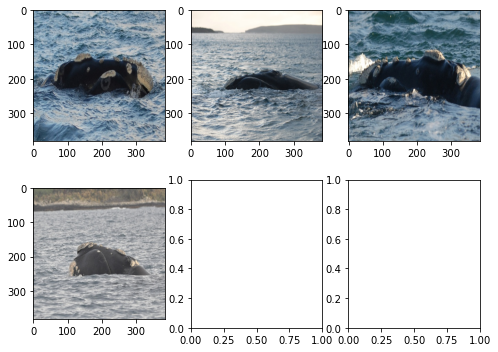

In [43]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np

train_df = pd.read_csv('train_kfold.csv')
img_dir = 'D:/whale_data/train_images-384-384/train_images-384-384'
ids = train_df[train_df.sample_count > 1].individual_id.unique()

def random_show(train_df):
    iid = np.random.choice(ids)
    samples = train_df[train_df.individual_id == iid]
    imgs = []
    for i, row in samples.iterrows():
        img = cv2.imread(f'D:/whale_data/train_images-384-384/train_images-384-384/{row.image}')[:, :, ::-1]
        if img is not None:
            imgs.append(img)

    fig = plt.figure(figsize=(8, 6))
    columns = 3
    rows = 2
    for i in range(0, columns*rows):
        fig.add_subplot(rows, columns, i+1)
        if i < len(imgs):
            
            plt.imshow(imgs[i])
    plt.show()

random_show(train_df)

In [51]:
pd.read_csv('data/train.csv').individual_id.nunique()

15587